In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import hickle as hkl 

In [2]:
np.random.seed(0)
# which GPU to use
# "-1,0,1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# DNN,CNN
modelType = "CNN"

# algorithm = "FEDAVG,FEDPER"
algorithm = "FEDAVG"

# UCI,REALWORLD_CLIENT
dataSetName = 'REALWORLD_CLIENT'

#BALANCED, UNBALANCED
dataConfig = "BALANCED"

#ADAM, SGD
optimizer = "SGD"

#0, 1
mantel = False
fastMode = False
euclid = True
asyncTest = False

savedClientModel = 0
showTrainVerbose = 0
segment_size = 128
num_input_channels = 6
learningRate = 0.01
dropout_rate = 0.5
localEpoch = 5
communicationRound = 200
seperateGraph = False



In [3]:
# filepath = mainDir + 'savedModels/'+architectureType+'/'+dataSetName+'/'
# os.makedirs('./trainingStats', exist_ok=True)

trainLossHistory = hkl.load("trainingStats/clientLossTrain.hkl" )
trainAccHistory = hkl.load( "trainingStats/clientAccuracyTrain.hkl" )
stdTrainLossHistory = hkl.load( "trainingStats/clientLossStdTrain.hkl" )
stdTrainAccHistory = hkl.load( "trainingStats/clientAccuracyStdTrain.hkl" )

testLossHistory = hkl.load( "trainingStats/clientLoss.hkl" )
testAccHistory = hkl.load( "trainingStats/clientAccuracy.hkl" )
stdTestLossHistory = hkl.load( "trainingStats/clientLossStd.hkl" )
stdTestAccHistory = hkl.load( "trainingStats/clientAccuracyStd.hkl" )


if(fastMode == False):
    clientStdTrainLossHistory = hkl.load( "trainingStats/clientAllLossStdTrain.hkl" )
    clientStdTrainAccHistory = hkl.load( "trainingStats/clientAllAccuracyStdTrain.hkl" )
    clientStdTestLossHistory = hkl.load( "trainingStats/clientAllLossStd.hkl" )
    clientStdTestAccHistory = hkl.load( "trainingStats/clientAllAccuracyStd.hkl" )

    clientTrainLossHistory = hkl.load( "trainingStats/clientAllLossTrain.hkl" )
    clientTrainAccHistory = hkl.load( "trainingStats/clientAllAccuracyTrain.hkl" )
    clientTestLossHistory = hkl.load( "trainingStats/clientAllLoss.hkl" )
    clientTestAccHistory = hkl.load( "trainingStats/clientAllAccuracy.hkl" )

if(algorithm != 'FEDPER'):
    serverTrainLossHistory = hkl.load( "trainingStats/serverLossTrain.hkl" )
    serverTrainAccHistory = hkl.load( "trainingStats/serverAccuracyTrain.hkl" )
    serverTestLossHistory = hkl.load( "trainingStats/serverLoss.hkl" )
    serverTestAccHistory = hkl.load( "trainingStats/serverAccuracy.hkl" )

In [4]:
def saveGraph(title = "",accuracyOrLoss = "Accuracy",asyTest = False,legendLoc = 'lower right'):
    if(asyTest):
        for stage in range(len(roundEnd)):
            plt.axvline(roundEnd[stage], 0, 1,color ="blue")
    plt.title(title)
    plt.ylabel(accuracyOrLoss)
    plt.xlabel('Communication Round')
    plt.legend(loc=legendLoc)
    plt.savefig(title.replace(" ", "")+'.png', dpi=100)
    plt.clf()



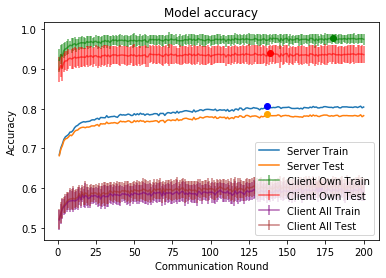

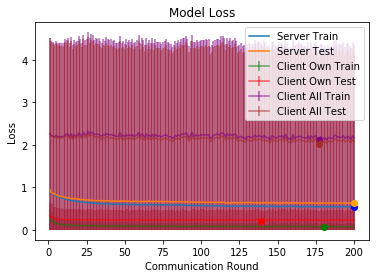

In [5]:
epoch_range = range(1, communicationRound+1)
if(seperateGraph):
    if(algorithm != "FEDPER"):
        plt.plot(epoch_range, serverTrainAccHistory, label = 'Server Train')
        plt.plot(epoch_range, serverTestAccHistory, label= 'Server Test')
        plt.plot(epoch_range, serverTrainAccHistory,markevery=[np.argmax(serverTrainAccHistory)], ls="", marker="o",color="blue")
        plt.plot(epoch_range, serverTestAccHistory,markevery=[np.argmax(serverTestAccHistory)], ls="", marker="o",color="orange")
        saveGraph("Server accuracy","Accuracy",asyTest = asyncTest)
        
    plt.errorbar(epoch_range, trainAccHistory, yerr=stdTrainAccHistory, label='Client Own Train',alpha=0.6)
    plt.errorbar(epoch_range, testAccHistory, yerr=stdTestAccHistory, label='Client Own Test',alpha=0.6)
    plt.plot(epoch_range, trainAccHistory,markevery=[np.argmax(trainAccHistory)], ls="", marker="o",color="green")
    plt.plot(epoch_range, testAccHistory,markevery=[np.argmax(testAccHistory)], ls="", marker="o",color="red")  
    saveGraph("Client own accuracy","Accuracy",asyTest = asyncTest)


    if(fastMode == False):
        plt.errorbar(epoch_range, clientTrainAccHistory, yerr=clientStdTrainAccHistory, label='Client All Train',alpha=0.6)
        plt.errorbar(epoch_range, clientTestAccHistory, yerr=clientStdTestAccHistory, label='Client All Test',alpha=0.6)
        plt.plot(epoch_range, clientTrainAccHistory,markevery=[np.argmax(clientTrainAccHistory)], ls="", marker="o",color="purple")
        plt.plot(epoch_range, clientTestAccHistory,markevery=[np.argmax(clientTestAccHistory)], ls="", marker="o",color="brown")  
        saveGraph("Client all accuracy","Accuracy",asyTest = asyncTest)

    if(algorithm != "FEDPER"):
        plt.plot(epoch_range, serverTrainLossHistory, label = 'Server Train')
        plt.plot(epoch_range, serverTestLossHistory, label= 'Server Test')
        plt.plot(epoch_range, serverTrainLossHistory,markevery=[np.argmax(serverTrainLossHistory)], ls="", marker="o",color="blue")
        plt.plot(epoch_range, serverTestLossHistory,markevery=[np.argmax(serverTestLossHistory)], ls="", marker="o",color="orange") 
        saveGraph("Server loss","Loss",asyTest = asyncTest,legendLoc = 'upper right')


    plt.errorbar(epoch_range, trainLossHistory, yerr=stdTrainLossHistory, label='Client Own Train',alpha=0.6)
    plt.errorbar(epoch_range, testLossHistory, yerr=stdTestLossHistory, label='Client Own Test',alpha=0.6)
    plt.plot(epoch_range, trainLossHistory,markevery=[np.argmax(trainLossHistory)], ls="", marker="o",color="green")
    plt.plot(epoch_range, testLossHistory,markevery=[np.argmax(testLossHistory)], ls="", marker="o",color="red") 
    
    saveGraph("Client own loss","Loss",asyTest = asyncTest,legendLoc = 'upper right')



    if(fastMode == False):
        plt.errorbar(epoch_range, clientTrainLossHistory, yerr=clientStdTrainLossHistory, label='Client All Train',alpha=0.6)
        plt.errorbar(epoch_range, clientTestLossHistory, yerr=clientStdTestLossHistory, label='Client All Test',alpha=0.6)
        plt.plot(epoch_range, clientTrainLossHistory,markevery=[np.argmax(clientTrainLossHistory)], ls="", marker="o",color="purple")
        plt.plot(epoch_range, clientTestLossHistory,markevery=[np.argmax(clientTestLossHistory)], ls="", marker="o",color="brown")  
        saveGraph("Client all loss","Loss",asyTest = asyncTest,legendLoc = 'upper right')
else:
    if(algorithm != "FEDPER"):
        plt.plot(epoch_range, serverTrainAccHistory, label = 'Server Train')
        plt.plot(epoch_range, serverTestAccHistory, label= 'Server Test')
        plt.plot(epoch_range, serverTrainAccHistory,markevery=[np.argmax(serverTrainAccHistory)], ls="", marker="o",color="blue")
        plt.plot(epoch_range, serverTestAccHistory,markevery=[np.argmax(serverTestAccHistory)], ls="", marker="o",color="orange") 

    plt.errorbar(epoch_range, trainAccHistory, yerr=stdTrainAccHistory, label='Client Own Train',alpha=0.6, color= "green")
    plt.errorbar(epoch_range, testAccHistory, yerr=stdTestAccHistory, label='Client Own Test',alpha=0.6, color='red')

    plt.plot(epoch_range, trainAccHistory,markevery=[np.argmax(trainAccHistory)], ls="", marker="o",color="green")
    plt.plot(epoch_range, testAccHistory,markevery=[np.argmax(testAccHistory)], ls="", marker="o",color="red")  

    # if(asyncTest):
    #     plt.axvline(roundEnd[0], 0, 1,color ="blue")
    #     plt.axvline(roundEnd[1], 0, 1,color ="blue")

    if(fastMode == False):
        plt.errorbar(epoch_range, clientTrainAccHistory, yerr=clientStdTrainAccHistory, label='Client All Train',alpha=0.6, color="purple")
        plt.errorbar(epoch_range, clientTestAccHistory, yerr=clientStdTestAccHistory, label='Client All Test',alpha=0.6, color="brown")
        plt.plot(epoch_range, clientTrainAccHistory,markevery=[np.argmax(clientTrainAccHistory)], ls="", marker="o",color="purple")
        plt.plot(epoch_range, clientTestAccHistory,markevery=[np.argmax(clientTestAccHistory)], ls="", marker="o",color="brown")  

        
    if(asyncTest):
        for stage in range(len(roundEnd)):
            plt.axvline(roundEnd[stage], 0, 1,color ="blue")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Communication Round')
    plt.legend(loc='lower right')
    plt.savefig('LearningAccuracy.png', dpi=100)
    plt.show()

    if(algorithm != "FEDPER"):
        plt.plot(epoch_range, serverTrainLossHistory, label = 'Server Train')
        plt.plot(epoch_range, serverTestLossHistory, label= 'Server Test')
        plt.plot(epoch_range, serverTrainLossHistory,markevery=[np.argmin(serverTrainLossHistory)], ls="", marker="o",color="blue")
        plt.plot(epoch_range, serverTestLossHistory,markevery=[np.argmin(serverTestLossHistory)], ls="", marker="o",color="orange") 

    plt.errorbar(epoch_range, trainLossHistory, yerr=stdTrainLossHistory, label='Client Own Train',alpha=0.6, color='green')
    plt.errorbar(epoch_range, testLossHistory, yerr=stdTestLossHistory, label='Client Own Test',alpha=0.6, color='red')
    plt.plot(epoch_range, trainLossHistory,markevery=[np.argmin(trainLossHistory)], ls="", marker="o",color="green")
    plt.plot(epoch_range, testLossHistory,markevery=[np.argmin(testLossHistory)], ls="", marker="o",color="red")  



    if(fastMode == False):
        plt.errorbar(epoch_range, clientTrainLossHistory, yerr=clientStdTrainLossHistory, label='Client All Train',alpha=0.6,color="purple")
        plt.errorbar(epoch_range, clientTestLossHistory, yerr=clientStdTestLossHistory, label='Client All Test',alpha=0.6,color="brown")
        plt.plot(epoch_range, clientTrainLossHistory,markevery=[np.argmin(clientTrainLossHistory)], ls="", marker="o",color="purple")
        plt.plot(epoch_range, clientTestLossHistory,markevery=[np.argmin(clientTestLossHistory)], ls="", marker="o",color="brown")  




    if(asyncTest):
        for stage in range(len(roundEnd)):
            plt.axvline(roundEnd[stage], 0, 1,color ="blue")
#         plt.axvline(roundEnd[1], 0, 1,color ="blue")

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Communication Round')
    plt.legend(loc= 'upper right')
    plt.savefig('LearningLoss.png', dpi=100)
    plt.show()

In [6]:
# Global Accuracy
serverTestAccHistory[:10]

array([0.68170148, 0.69787736, 0.70694033, 0.71892142, 0.72400006,
       0.72531882, 0.72867184, 0.733526  , 0.73208098, 0.73637397])

In [7]:
# Generalized Accuracy
clientTestAccHistory[:10]

array([0.52236523, 0.53799407, 0.55107079, 0.55681634, 0.56095197,
       0.56692197, 0.57035271, 0.57270493, 0.57286929, 0.57455544])

In [8]:
# Global Accuracy
serverTestAccHistory[:10]

array([0.68170148, 0.69787736, 0.70694033, 0.71892142, 0.72400006,
       0.72531882, 0.72867184, 0.733526  , 0.73208098, 0.73637397])